# PyMC-GP Examples

In [ ]:
# 1. 라이브러리 임포트
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

# 재현성을 위한 랜덤 시드 설정
np.random.seed(42)

# 2. 비선형 데이터 생성
# ---------------------
# GP가 학습할 샘플 데이터를 만듭니다. sin 함수에 노이즈를 추가합니다.
X = np.linspace(0, 10, 20)[:, None]  # 20개의 훈련 데이터 포인트
true_func = lambda x: np.sin(x) * 1.5
y = true_func(X).ravel() + np.random.normal(0, 0.4, 20) # 실제 함수값에 노이즈 추가


# 3. PyMC를 이용한 GP 모델 정의
# ----------------------------
with pm.Model() as gp_model:
    # --- 커널 하이퍼파라미터에 대한 사전분포(Priors) 설정 ---
    # 길이척도(lengthscale, ℓ): 함수가 얼마나 부드러운지를 제어합니다.
    # Gamma 분포를 사용해 양수 값을 가지도록 합니다.
    lengthscale = pm.Gamma("ℓ", alpha=2, beta=0.5)

    # 출력 스케일(output-scale, η): 함수의 평균적인 변동폭을 제어합니다.
    # HalfCauchy 분포는 양수 값을 가지며, 가끔 큰 값이 나올 수 있도록 유연성을 줍니다.
    eta = pm.HalfCauchy("η", beta=3)

    # --- 커널(공분산 함수) 정의 ---
    # ExpQuad(Squared Exponential) 커널을 사용합니다. 가장 일반적인 선택입니다.
    # 위에서 정의한 하이퍼파라미터(확률 변수)를 커널에 전달합니다.
    cov_func = eta**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=lengthscale)

    # --- GP 사전분포(Prior) 정의 ---
    # pm.gp.Latent를 사용해 잠재(Latent) GP를 정의합니다.
    # 이 GP는 우리가 추정하고자 하는 실제 함수 f(x)에 대한 사전 믿음입니다.
    gp = pm.gp.Latent(cov_func=cov_func)

    # 모델이 학습할 데이터 X에 대해 GP 사전분포로부터 함수 f를 생성합니다.
    f = gp.prior("f", X=X)

    # --- 가능도(Likelihood) 정의 ---
    # 관측 노이즈(sigma, σ)에 대한 사전분포를 설정합니다.
    sigma = pm.HalfCauchy("σ", beta=3)

    # 관측된 데이터 y는 잠재 함수 f에 정규분포 노이즈(sigma)가 더해진 결과라고 가정합니다.
    # 이것이 데이터와 GP 모델을 연결하는 핵심 부분입니다.
    y_obs = pm.Normal("y_obs", mu=f, sigma=sigma, observed=y)


# 4. MCMC를 이용한 사후 분포 추론
# -------------------------------
with gp_model:
    # PyMC의 NUTS 샘플러를 사용해 사후 분포에서 2000개의 샘플을 추출합니다.
    # 이 과정에서 f, ℓ, η, σ 등 모든 확률 변수의 사후 분포가 계산됩니다.
    trace = pm.sample(2000, tune=1000, cores=1)


Initializing NUTS using jitter+adapt_diag...
/home/lsw91/Workspace/pymc-gp/.venv/lib/python3.11/site-packages/pytensor/link/c/cmodule.py:2968: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Sequential sampling (2 chains in 1 job)
NUTS: [ℓ, η, f_rotated_, σ]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 66 seconds.
There were 376 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


TypeError: Latent.conditional() missing 1 required positional argument: 'Xnew'

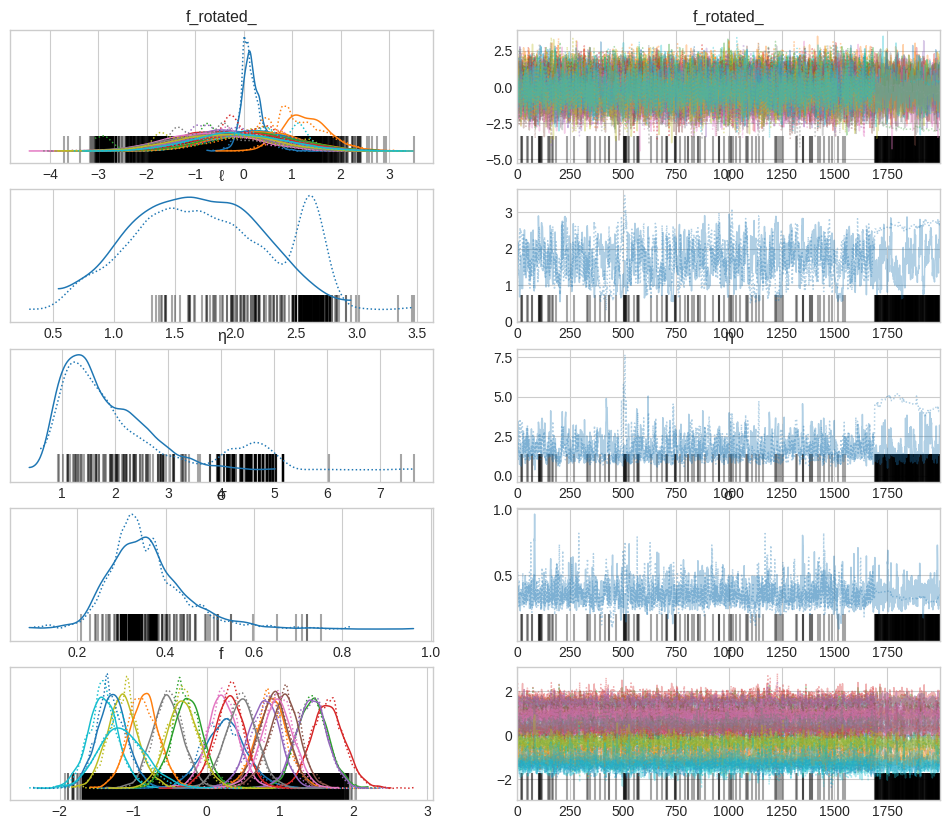

In [9]:
az.plot_trace(trace)
plt.show()

In [11]:
# 5. 새로운 데이터에 대한 예측
# ---------------------------
# 예측을 수행할 새로운 x좌표(X_new)를 촘촘하게 생성합니다.
Xnew = np.linspace(-2, 12, 100)[:, None]

with gp_model:
    # gp.conditional 메서드는 학습된 사후 분포를 기반으로,
    # 새로운 입력 X_new에 대한 함수 값(f_new)의 분포를 계산해줍니다.
    f_pred = gp.conditional("f_pred", Xnew=Xnew)

ValueError: Variable name f_pred already exists.

In [12]:
with gp_model:
    # 위에서 정의한 조건부 분포로부터 예측 샘플을 추출합니다.
    # 이것이 "사후 예측 샘플링" 과정입니다.
    pred_samples = pm.sample_posterior_predictive(trace, var_names=["f_pred"])

Sampling: [f_pred]


Output()

In [15]:
pred_samples

Inference data with groups:
	> posterior_predictive
	> observed_data

In [18]:
pred_samples.posterior_predictive["f_pred"]

<xarray.DataArray 'f_pred' (chain: 2, draw: 2000, f_pred_dim_0: 100)> Size: 3MB
array([[[-6.11985426e-01, -3.79761491e-01, -2.02484116e-01, ...,
         -2.48408282e+00, -2.18507251e+00, -1.85175034e+00],
        [-2.36850338e+00, -2.33059873e+00, -2.26942929e+00, ...,
         -3.87003274e+00, -3.83756161e+00, -3.77287319e+00],
        [-9.82453093e-01, -1.03706747e+00, -1.07075240e+00, ...,
         -1.25617374e+00, -1.03361900e+00, -7.96512456e-01],
        ...,
        [-4.39330633e+00, -4.26170469e+00, -4.09631677e+00, ...,
         -3.66960465e+00, -3.70014729e+00, -3.69970269e+00],
        [-4.78117507e+00, -4.60641627e+00, -4.40621781e+00, ...,
         -3.14577821e+00, -3.10384289e+00, -3.04059595e+00],
        [-8.64644118e-01, -8.97029228e-01, -9.20210181e-01, ...,
         -1.73390552e+00, -1.64176470e+00, -1.53012196e+00]],

       [[ 5.27562002e-01,  7.32712055e-01,  9.44670905e-01, ...,
         -7.49618078e-01, -1.05113725e+00, -1.33453353e+00],
        [-7.05315130e-01, -4.90081859e-01, -2.86907990e-01, ...,
          1.00274740e-03,  2.84685054e-01,  5.15840381e-01],
        [-2.30626663e-03,  3.30941445e-02,  3.50301485e-02, ...,
         -1.29637273e+00, -1.14562735e+00, -9.98187077e-01],
        ...,
        [-2.09895459e+00, -1.99438000e+00, -1.86916129e+00, ...,
         -3.99143188e+00, -4.14776532e+00, -4.28470153e+00],
        [-2.13764944e+00, -2.01125624e+00, -1.87066918e+00, ...,
         -4.23198188e+00, -4.45932830e+00, -4.68090821e+00],
        [-1.71204090e+00, -1.65452511e+00, -1.57558533e+00, ...,
         -4.25396996e+00, -4.47311929e+00, -4.68194312e+00]]],
      shape=(2, 2000, 100))
Coordinates:
  * chain         (chain) int64 16B 0 1
  * draw          (draw) int64 16kB 0 1 2 3 4 5 ... 1995 1996 1997 1998 1999
  * f_pred_dim_0  (f_pred_dim_0) int64 800B 0 1 2 3 4 5 6 ... 94 95 96 97 98 99

In [22]:
posterior_predictive_samples

<xarray.DataArray 'f_pred' (f_pred_dim_0: 100, sample: 4000)> Size: 3MB
array([[-0.61198543, -2.36850338, -0.98245309, ..., -2.09895459,
        -2.13764944, -1.7120409 ],
       [-0.37976149, -2.33059873, -1.03706747, ..., -1.99438   ,
        -2.01125624, -1.65452511],
       [-0.20248412, -2.26942929, -1.0707524 , ..., -1.86916129,
        -1.87066918, -1.57558533],
       ...,
       [-2.48408282, -3.87003274, -1.25617374, ..., -3.99143188,
        -4.23198188, -4.25396996],
       [-2.18507251, -3.83756161, -1.033619  , ..., -4.14776532,
        -4.4593283 , -4.47311929],
       [-1.85175034, -3.77287319, -0.79651246, ..., -4.28470153,
        -4.68090821, -4.68194312]], shape=(100, 4000))
Coordinates:
  * f_pred_dim_0  (f_pred_dim_0) int64 800B 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
  * sample        (sample) object 32kB MultiIndex
  * chain         (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1
  * draw          (sample) int64 32kB 0 1 2 3 4 5 ... 1995 1996 1997 1998 1999

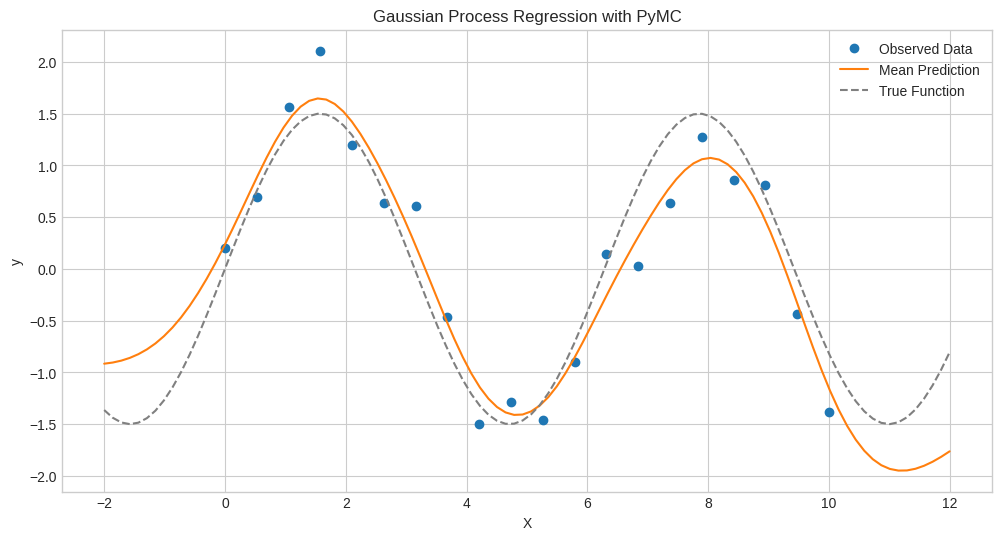

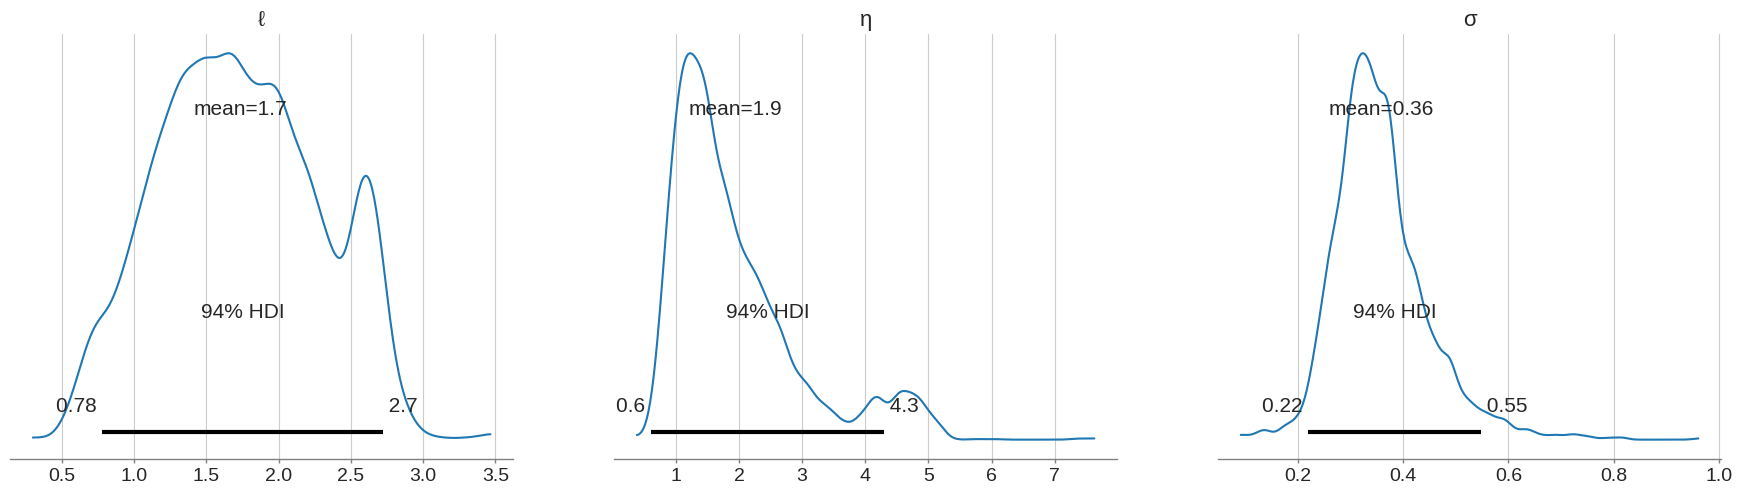

In [23]:
# 6. 결과 시각화
# --------------
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 6))

# 사후 예측의 평균과 신뢰구간 계산
# pred_samples에서 f_pred의 샘플들을 가져옵니다.
posterior_predictive_samples = az.extract(pred_samples.posterior_predictive, var_names='f_pred')
mean_pred = posterior_predictive_samples.mean(axis=1) # 샘플들의 평균 -> 예측 평균 함수
# hdi_94 = az.hdi(posterior_predictive_samples, hdi_prob=0.94) # 94% 최고 밀도 구간(HDI)

# 원본 데이터 플로팅 (파란색 점)
ax.plot(X, y, 'o', color='tab:blue', label="Observed Data")

# GP 예측 평균 플로팅 (주황색 선)
ax.plot(X_new, mean_pred, "-", color='tab:orange', label="Mean Prediction")

# # GP 예측의 94% 신뢰구간 플로팅 (주황색 음영)
# ax.fill_between(X_new.ravel(),
#                 hdi_94[:,0],
#                 hdi_94[:,1],
#                 color='tab:orange',
#                 alpha=0.3,
#                 label="94% HDI (Uncertainty)")

# 실제 함수 플로팅 (회색 점선)
ax.plot(X_new, true_func(X_new), '--', color='gray', label='True Function')


ax.set_xlabel("X")
ax.set_ylabel("y")
ax.set_title("Gaussian Process Regression with PyMC")
ax.legend()
plt.show()

# 하이퍼파라미터의 사후 분포 시각화
az.plot_posterior(trace, var_names=["ℓ", "η", "σ"]);
plt.show()